## First Aproach

- Simular $n$ termoeléctricas ($t_i$ es el valor de generación máxima de la termoeléctrica $i$)
- El día 0 funcionan todas
- Si todas funcionan Oferta $\geq$ Demanda
- Simular tiempo de rotura (Weibull)
- Todas se pueden reparar a la vez
- Tiempo de reparación Lognormal
- Existen $m$ circuitos ($c_j$ es el valor de demanda del circuito $j$)
- $\delta_{ik}$ es un parámetro binario que expresa si la termoeléctrica $i$ está activa el día $k$
- $\alpha_{jk}$ es un parámetro binario que expresa si el circuito $j$ está activo el día $k$
- Existe capacidad de almacenamiento ($a_k$ es la capacidad de almacenamiento del sistema en el día $k$)
- $a_0 = 0$
- $a_k = \sum_{i=1}^{n} t_i\delta_{ik} + a_{k-1} - \sum_{j=1}^{m} c_j\alpha_{jk}, a_k \geq 0$
- No simularemos mantenimientos planificados, solo reparación por rotura
- No tendremos en cuenta fallas internas de los circuitos
- No habrán circuitos que dependan de termoeléctricas específicas
- La afectación a los circuitos se hará de manera proporcional (con una proporción que definiremos) y rotativa, cuando sea necesario
- Al final de la simulación calcularemos una afectación (fórmula por determinar)

In [185]:
from App.modules.weibull import Weibull
from App.modules.lognormal import LogNormal
from App.modules.event import Event
from App.modules.thermoelectric import ThermoElectric
import random as rnd
import numpy as np

In [186]:
def generate_thermoelectrics(days, thermoelectrics_amount):
    thermoelectrics = []
    for i in range(thermoelectrics_amount):
        w = Weibull(rnd.uniform(40, 70), rnd.uniform(1,3))
        l = LogNormal(rnd.uniform(2,2.5), rnd.uniform(0.2,0.4))
        o = rnd.randrange(0, 1000)
        t = ThermoElectric(o , w, l)
        t.planificate_events(days)
        thermoelectrics.append(t)

    return thermoelectrics

In [187]:
days = 365
thermoelectrics_amount = 20
thermoelectrics = generate_thermoelectrics(days, thermoelectrics_amount)

0
322
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


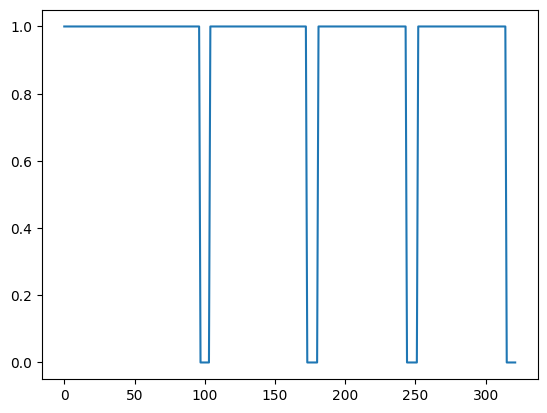

Weibull Distribution:
Scale: 69.78836814151936
Shape: 2.2625689747426856
 - - - - - - - - - - - -
LogNormal Distribution:
Mean: 2.3031902818252945
Des: 0.2928880300704278


In [194]:
for i in range(1):
    print(i)
    thermoelectrics[i].plot(0, 365)
    thermoelectrics[i].get_distributions_info()

In [189]:
def get_next_general_event(thermoelectrics_list, days, current_day):
    next_event = days
    next_thermoelectric = None
    for t in thermoelectrics_list:
        tmp = t.get_next_future_event_day()
        if tmp < next_event and tmp > current_day:
            next_event = tmp
            next_thermoelectric = t
    return (next_event, next_thermoelectric)

In [190]:
get_next_general_event(thermoelectrics, days, 4)

(9.808810369418946,
 <App.modules.thermoelectric.ThermoElectric at 0x7e9520365ff0>)

In [191]:
def simulate(sim_thermoelectrics, days):
    current_day = 0
    working_thermoelectrics = []
    working_thermoelectrics.append(len(sim_thermoelectrics))
    while current_day < days:
        next_event, next_thermoelectric = get_next_general_event(sim_thermoelectrics, days, current_day)
        for i in range(int(np.floor(current_day)), int(np.floor(next_event))-1):
            working_thermoelectrics.append(working_thermoelectrics[-1])
        current_day = next_event
        if next_thermoelectric is not None:
            next_thermoelectric.pop_next_future_event()
            while True:
                new_next_event, new_next_thermoelectric = get_next_general_event(sim_thermoelectrics, days, current_day)
                if np.floor(current_day) == np.floor(new_next_event):
                    new_next_thermoelectric.pop_next_future_event()
                    current_day = new_next_event
                else: 
                    break
            count = 0
            for t in sim_thermoelectrics:
                if t.is_working():
                    
                    count += 1
            working_thermoelectrics.append(count)

        else:
            working_thermoelectrics.append(working_thermoelectrics[-1])
            break
    return working_thermoelectrics

In [192]:
import copy

tmp = copy.deepcopy(thermoelectrics)
working_thermoelectrics = simulate(tmp, days)

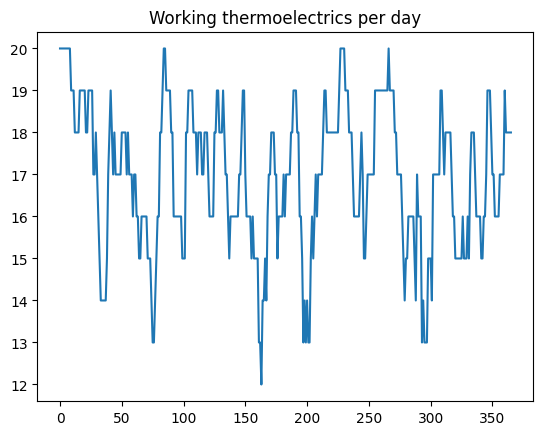

In [193]:
import matplotlib.pyplot as plt

plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
plt.xlabel = 'Days'
plt.ylabel = 'Working thermoelectrics'
plt.show()

In [196]:
def simulate_agent(thermoelectrics, days, agent=None):
    working_thermoelectrics = []
    working_thermoelectrics.append(np.ones(len(thermoelectrics)))

    event_date, event_thermoelectric = get_next_general_event(thermoelectrics, days, True)

    for current_day in range(0, days):
        
        if agent is not None:
            agent.Manage_Thermoelectrics()
        
        while(event_thermoelectric != None and np.floor(event_date) == current_day):
            event_thermoelectric.pop_next_future_event()
            event_date, event_thermoelectric = get_next_general_event(thermoelectrics, days, current_day)

        thermoelectrics_state = [t.is_working() for t in thermoelectrics]
        working_thermoelectrics.append(thermoelectrics_state)    

        if agent is not None:
            agent.Manage_Circuits()

    return working_thermoelectrics

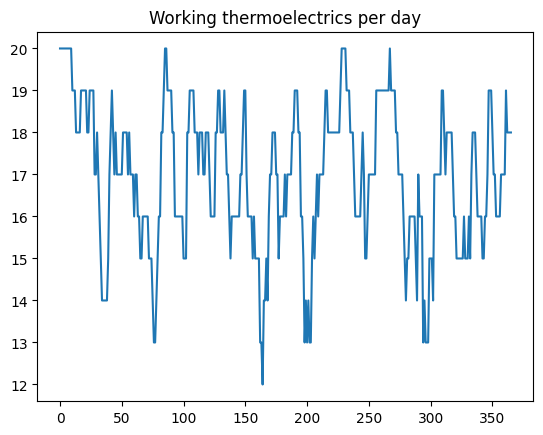

In [198]:
tmp = copy.deepcopy(thermoelectrics)
working_thermoelectrics = simulate_agent(tmp, days)
working_thermoelectrics = [sum(x) for x in working_thermoelectrics]

plt.plot(working_thermoelectrics)
plt.title('Working thermoelectrics per day')
plt.xlabel = 'Days'
plt.ylabel = 'Working thermoelectrics'
plt.show()